# OptML project experiments

**DEPENDENCIES**: The code was tested using python 3.8 with the latest versions of
- numpy
- matplotlib
- seaborn
- torch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
from typing import Optional
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import math

# Experiment 1: Minimization of curvature modulated parabola

## Part 1: Impact of frequency

In [2]:
class Options:
    """Class containing all parameters"""
    def __init__(self):
        # Env params
        self.T = 8
        self.omegas = [0.1,0.2,0.4,0.8,1.6,3.2]
        self.c = 1
        self.eps = 10**-5
        self.A = 2
        self.t = 0
        self.lr = 1e-3
        self.timesteps = 55
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
opt = Options()

def f(x:torch.Tensor, t:int, omega:float, A:float):
    return alpha(t,omega, A) * (x.pow(2))
    
def alpha(t:int, omega:torch.Tensor, A:float):
    if t <= opt.T:
        return opt.c
    return (A/2) * (1 + torch.sin(omega*t) + opt.eps)

random.seed(42)
torch.manual_seed(42)

In [3]:
adam_deltas = defaultdict(list)
sgd_deltas = defaultdict(list)

for omega in opt.omegas:
    omega_tensor = torch.Tensor([omega])
    
    x_adam = torch.Tensor([2]) #torch.randn(1)
    x_sgd = x_adam.clone()
    x_adam.requires_grad_(True)
    x_sgd.requires_grad_(True)
    
    adam_opt = optim.Adam([x_adam], lr=opt.lr)
    sgd_opt = optim.SGD([x_sgd], lr=opt.lr)
    
    for t in range(opt.timesteps):
        # Perform Adam and SGD steps
        y_adam = f(x_adam, t, omega_tensor, opt.A)
        adam_opt.zero_grad()
        y_adam.backward()
        adam_opt.step()
        
        y_sgd = f(x_sgd, t, omega_tensor, opt.A)
        sgd_opt.zero_grad()
        y_sgd.backward()
        sgd_opt.step()
        
        # Append to results
        adam_deltas[omega].append(abs(x_adam.detach().item()))
        sgd_deltas[omega].append(abs(x_sgd.detach().item()))

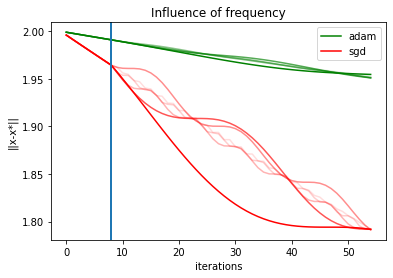

In [4]:
alph = 1
label = True

for omega in opt.omegas:
    x = np.array(adam_deltas[omega])
    y = np.array(sgd_deltas[omega])
    L = np.array(list(range(opt.timesteps)))
    
    if label == True:
        plt.plot(L, x, color='green', label='adam', alpha=alph)
        plt.plot(L, y, color='red', label='sgd', alpha=alph)
        label = False
    else:
        plt.plot(L, x, color='green', alpha=alph)
        plt.plot(L, y, color='red', alpha=alph)
        
    plt.axvline(opt.T)
    plt.xlabel('iterations')
    plt.ylabel('||x-x*||')
    alph /= 1.5

plt.title('Influence of frequency')
plt.legend()
plt.show()

## Part 2: Impact of amplitude

In [5]:
opt.omegas = 0.4
opt.A = [1, 2, 4, 8]

In [6]:
adam_deltas = defaultdict(list)
sgd_deltas = defaultdict(list)

for A in opt.A:
    omega_tensor = torch.Tensor([opt.omegas])
    
    x_adam = torch.Tensor([2]) #torch.randn(1)
    x_sgd = x_adam.clone()
    x_adam.requires_grad_(True)
    x_sgd.requires_grad_(True)
    
    adam_opt = optim.Adam([x_adam], lr=opt.lr)
    sgd_opt = optim.SGD([x_sgd], lr=opt.lr)
    
    for t in range(opt.timesteps):
        # Perform Adam and SGD steps
        y_adam = f(x_adam, t, omega_tensor, A)
        adam_opt.zero_grad()
        y_adam.backward()
        adam_opt.step()
        
        y_sgd = f(x_sgd, t, omega_tensor, A)
        sgd_opt.zero_grad()
        y_sgd.backward()
        sgd_opt.step()
        
        # Append to results
        adam_deltas[A].append(abs(x_adam.detach().item()))
        sgd_deltas[A].append(abs(x_sgd.detach().item()))

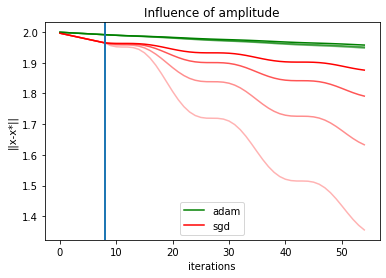

In [7]:
alph = 1
label = True

for A in opt.A:
    x = np.array(adam_deltas[A])
    y = np.array(sgd_deltas[A])
    L = np.array(list(range(opt.timesteps)))
    
    if label == True:
        plt.plot(L, x, color='green', label='adam', alpha=alph)
        plt.plot(L, y, color='red', label='sgd', alpha=alph)
        label = False
    else:
        plt.plot(L, x, color='green', alpha=alph)
        plt.plot(L, y, color='red', alpha=alph)
        
    plt.axvline(opt.T)
    plt.xlabel('iterations')
    plt.ylabel('||x-x*||')
    alph /= 1.5

plt.title('Influence of amplitude')
plt.legend()
plt.show()

# Experiment 2: Classification of non-stationary Gaussian processes

In [8]:
%matplotlib notebook

## Model the environment

In [9]:
class Env2(object):
    """Experiment2 environment
    
    Arguments
    ---------
    d: int
        dimensionality of the environment 
        
    lambda_: float
        parameter of the lifetime exponential distribution
        
    batch_size: int
        batch size
        
    N: int
        maximum number of samples to use to solve the least squares problem
        
    p: torch.Tensor
        parameter of the bernoulli label distribution. Must be of size (1)
    
    Attributes
    ----------
    Y: torch.disibutions.distribution.Distribution
        labels distribution
        
    X0: torch.disibutions.distribution.Distribution
        negative samples distribution
        
    X1: torch.disibutions.distribution.Distribution
        positive samples distribution
        
    T: torch.disibutions.distribution.Distribution
        lifetime of X0 and X1 distribution
        
    counter: int
        counts calls to get_batch
        
    tau: int
        lifetime of X0 and X1
    
    mu0, sigma0: torch.Tensor, torch.Tensor
        parameters of Gaussian distribution X0
        
    mu1, sigma1: torch.Tensor, torch.Tensor
        parameters of Gaussian distribution X1
        
    w: torch.Tensor
        current least squares solution
    """
    def __init__(self, d:int, lambda_:float, batch_size: int, N: int, 
                 p:Optional[torch.Tensor]=torch.Tensor([0.5])):
        # Attributes
        self.d = d
        self.lambda_ = lambda_
        self.batch_size = batch_size
        self.N = N
        # label random variable
        self.Y = td.bernoulli.Bernoulli(p)
        # data random variables
        self.build_data()
        self.compute_min()
        # lifetime random variable
        self.T = td.exponential.Exponential(lambda_)
        self.reset_lifetime()
        # counter (for lifetime)
        self.counter = 0
    
    def reset(self):
        """reset environment internals"""
        self.counter = 0
        self.reset_lifetime()
        self.build_data()
        self.compute_min()
        
    def reset_lifetime(self):
        """sample lifetime"""
        self.tau = math.ceil((self.T.sample()))
        
    def build_data(self):
        """Build two normal distributions"""
        mus = torch.randn(self.d, 2)
        sigmas = torch.randn(self.d, 2).pow_(2)
        # magic number
        sigmas[sigmas<1]=1
        self.mu0, self.mu1 = mus[:,0], mus[:,1]
        self.sigma0, self.sigma1 = sigmas[:,0], sigmas[:,1]
        self.X0 = td.normal.Normal(loc=self.mu0, scale=self.sigma0)
        self.X1 = td.normal.Normal(loc=self.mu1, scale=self.sigma1)
        
    def compute_min(self):
        """solve least squares"""
        # Sample data
        x0 = self.X0.sample((self.N//2,))
        x1 = self.X1.sample((self.N//2,))
        X = torch.cat([x0, x1], dim=0)
        Y = torch.cat([
            torch.zeros((self.N//2,)), torch.ones((self.N//2,))
        ], dim=0)
        # Add bias dimension
        X = torch.cat([
            torch.ones((X.shape[0],1)), X
        ], dim=1)
        # Shuffle
        idx = torch.randperm(self.N)
        X = X[idx]
        Y = Y[idx]
        # solve least squares
        w, _= torch.lstsq(Y, X)
        self.w = w[:self.d+1]
    
    def get_batch(self, bias:bool=False):
        """produce a batch of data and labels"""
        # Sample from Y, get the number of 0s and 1s 
        n0 = (self.Y.sample((self.batch_size,))==0).size(0)
        n1 = self.batch_size-n0
        # Sample data points
        x0 = self.X0.sample((n0,))
        x1 = self.X1.sample((n1,))
        X = torch.cat([x0, x1], dim=0)
        # Add bias dimension
        if bias:
            X = torch.cat([
                torch.ones((X.shape[0],1)), X
            ], dim=1)
        # Build labels
        Y = torch.cat([
            torch.zeros((n0,1)), torch.ones((n1,1))
        ], dim=0)
        # Shuffle
        idx = torch.randperm(self.batch_size)
        X = X[idx]
        Y = Y[idx]
        # increment lifetime counter
        self.counter += 1
        if self.counter==self.tau:
            self.reset()
            
        return X, Y

## Instantiate environment

In [10]:
class Options:
    """Class containing all parameters"""
    def __init__(self):
        # Env params
        self.d = 100
        self.lambda_ = 0.01
        self.batch_size= 128
        self.N = int(1e4)
        self.p = torch.Tensor([0.5])
        self.bias_in_batch = False
        # Other params
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.lr = 1e-3
opt = Options()

In [11]:
env = Env2(opt.d, opt.lambda_, opt.batch_size, opt.N, opt.p)

## Logistic regression model

In [12]:
class LinearModel(nn.Module):
    def __init__(self, d, bias):
        super().__init__()
        self.f = nn.Linear(in_features=d, out_features=1, bias=bias)
    def forward(self, x):
        return self.f(x)

## Experiment function

In [13]:
def run_experiment(d, b1=None, b2=None):
    # Create models
    d_ = d
    bias_ = not opt.bias_in_batch
    adam_model = LinearModel(d_, bias_).to(opt.device)
    sgd_model = LinearModel(d_, bias_).to(opt.device)
    # Create loss and optimizers
    criterion = nn.BCEWithLogitsLoss().to(opt.device)
    if b1 is not None and b2 is not None:
        adam = optim.Adam(adam_model.parameters(), lr=opt.lr, betas=(b1, b2))
    else:
        adam = optim.Adam(adam_model.parameters(), lr=opt.lr)
    sgd = optim.SGD(sgd_model.parameters(), lr=opt.lr)
    gen = 0
    # Reset env
    env = Env2(d, opt.lambda_, opt.batch_size, opt.N, opt.p)
    # Init plots
    plt.ion()
    plt.rcParams['figure.figsize'] = (10,15)
    fig = plt.figure()
    ax_l = fig.add_subplot(311)
    ax_avg = fig.add_subplot(312)
    ax_avg_sq = fig.add_subplot(313)
    fig.canvas.draw()
    adam_losses = []
    sgd_losses = []
    # Init params
    avg = None
    avg_sq = None
    adam_gnorm = []
    sgd_gnorm = []
    n = 0
    while gen < 4000:
        gen += 1
        # Get batch
        X,Y = env.get_batch(opt.bias_in_batch)
        X = X.to(opt.device)
        Y = Y.to(opt.device)
        # Adam model
        Yp = adam_model(X)
        loss = criterion(Yp, Y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        adam_losses.append(loss.cpu().detach().item())
        # Sgd model
        Yp = sgd_model(X)
        loss = criterion(Yp, Y)
        sgd.zero_grad()
        loss.backward()
        sgd.step()
        sgd_losses.append(loss.cpu().detach().item())
        # Get states
        ks = []
        vs = []
        for i, (k,v) in enumerate(adam.state.items()):
            ks.append(k)
            vs.append(v)
        avg_ = vs[0]['exp_avg'].cpu().numpy().reshape(-1,1)
        avg_sq_ = vs[0]['exp_avg_sq'].cpu().numpy().reshape(-1,1)
        if n==0:
            avg = avg_
            avg_sq = avg_sq_
            n += 1
        else:
            avg = np.concatenate([avg, avg_], axis=1)
            avg_sq = np.concatenate([avg_sq, avg_sq_], axis=1)
        # Compute gradient norms
        adam_gnorm.append(torch.norm(
            torch.cat([adam_model.f.weight.grad.detach().cpu(), 
                       adam_model.f.bias.grad.unsqueeze(-1).detach().cpu()], 
                      dim=1),
            p=2
        ).item())
        sgd_gnorm.append(torch.norm(
            torch.cat([sgd_model.f.weight.grad.detach().cpu(), 
                       sgd_model.f.bias.grad.unsqueeze(-1).detach().cpu()], 
                      dim=1),
            p=2
        ).item())
        # Plots when there are changes
        if env.counter==0:
            
            # plot losses
            ax_l.clear()
            ax_l.plot(np.arange(gen), adam_losses, c='g', label='adam')
            ax_l.plot(np.arange(gen), sgd_losses, c='r', label='sgd')
            ax_l.set_title(f'loss in dimension {d}')
            ax_l.set_xlabel('Number of batches')
            ax_l.set_ylabel('BCE')
            ax_l.legend()
            # Plot Adama avg_exp
            for k in range(d):
                ax_avg.plot(np.arange(gen), avg[k], label=f'dim({k})')
            ax_avg.set_title(f'Evolution of avg in dimension {d}')
            ax_avg.set_xlabel(f'Number of batches')
            ax_avg.set_ylabel('exponential average')
            # Plot Adam avg_exp_sq
            for k in range(d):
                ax_avg_sq.plot(np.arange(gen), avg_sq[k], label=f'dim({k})')
            ax_avg_sq.set_title(f'Evolution of avg_sq in dimension {d}')
            ax_avg_sq.set_xlabel(f'Number of batches')
            ax_avg_sq.set_ylabel('exponential average square')
            # Draw
            fig.canvas.draw()    

## Part 1: Impact of dimension

<IPython.core.display.Javascript object>


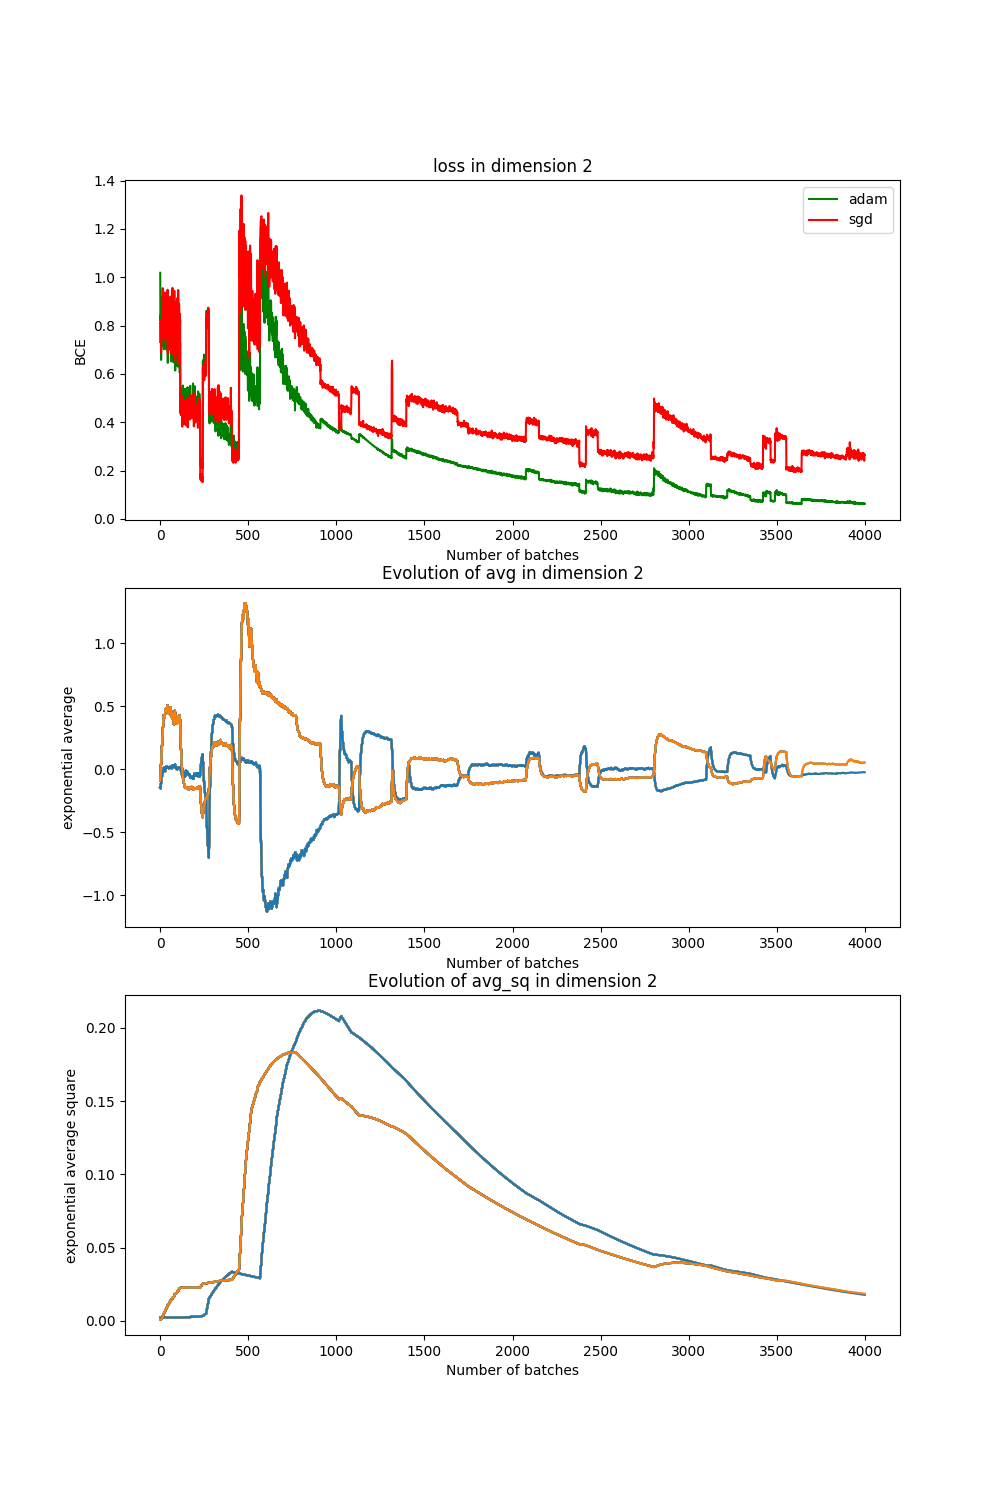

In [14]:
run_experiment(2)

<IPython.core.display.Javascript object>


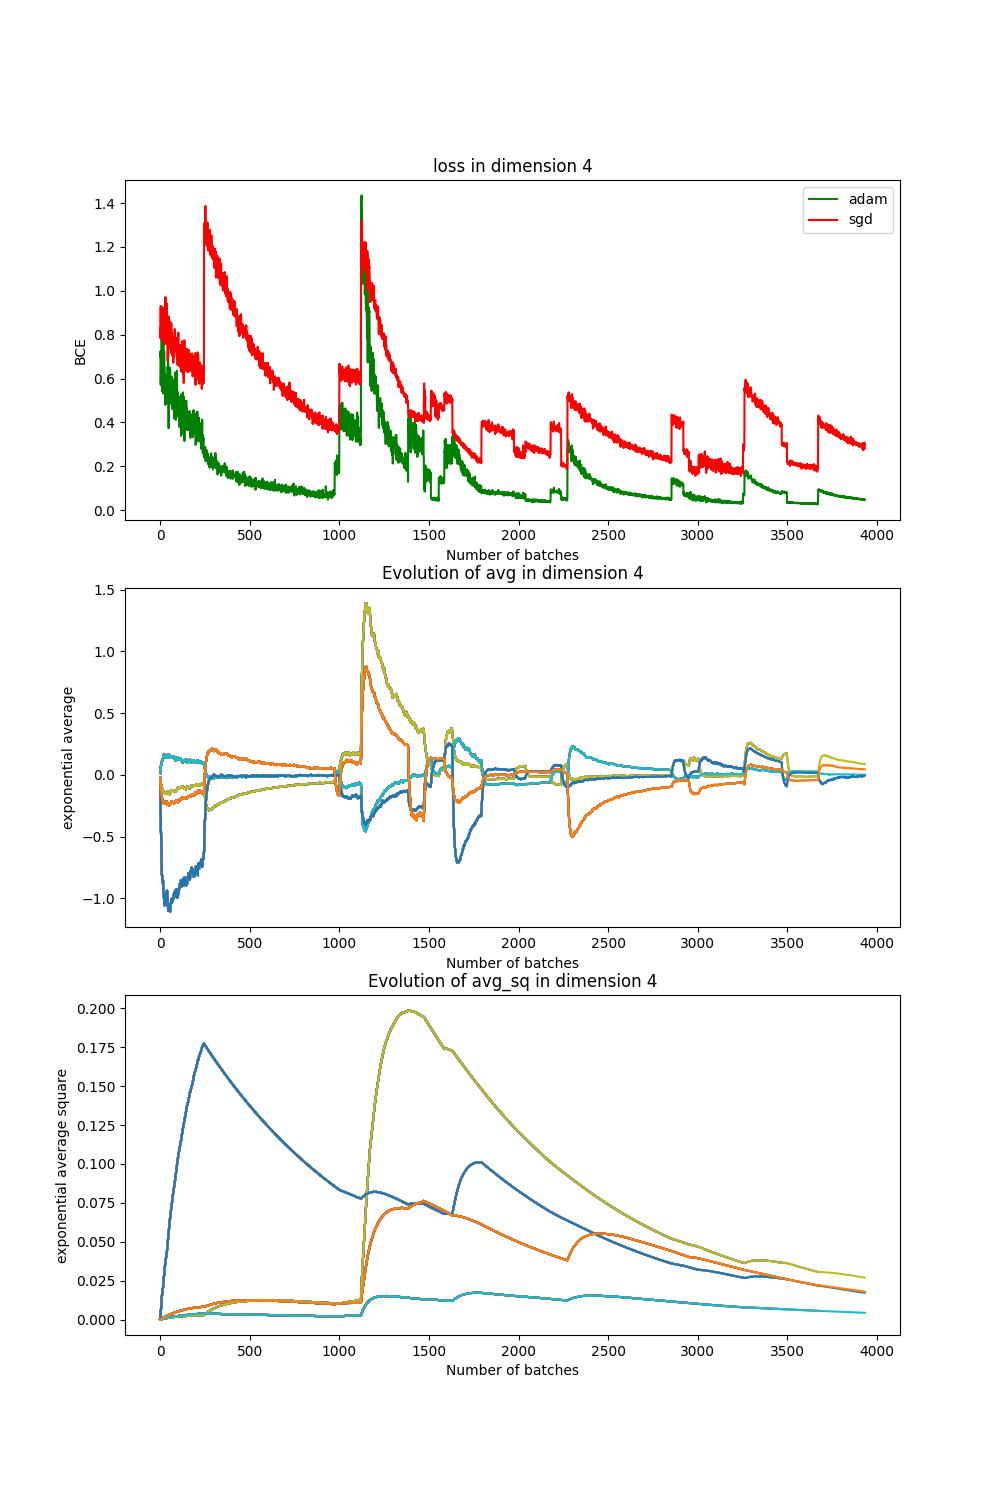

In [15]:
run_experiment(4)

<IPython.core.display.Javascript object>


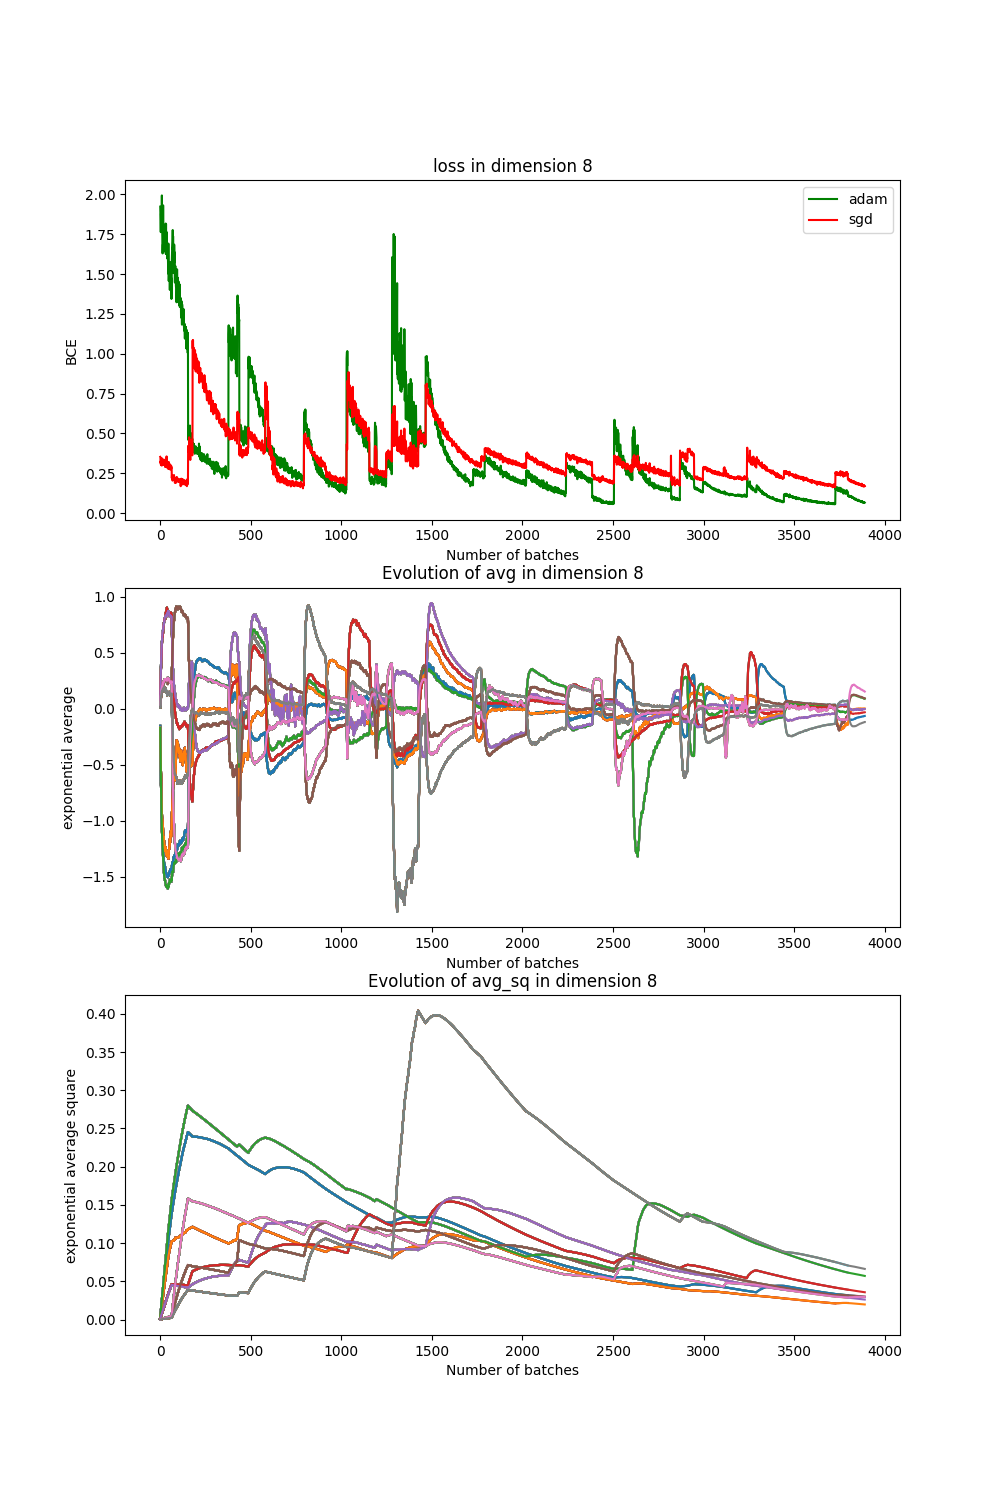

In [16]:
run_experiment(8)

## Part 2: Impact of $\beta_1$ and $\beta_2$

<IPython.core.display.Javascript object>


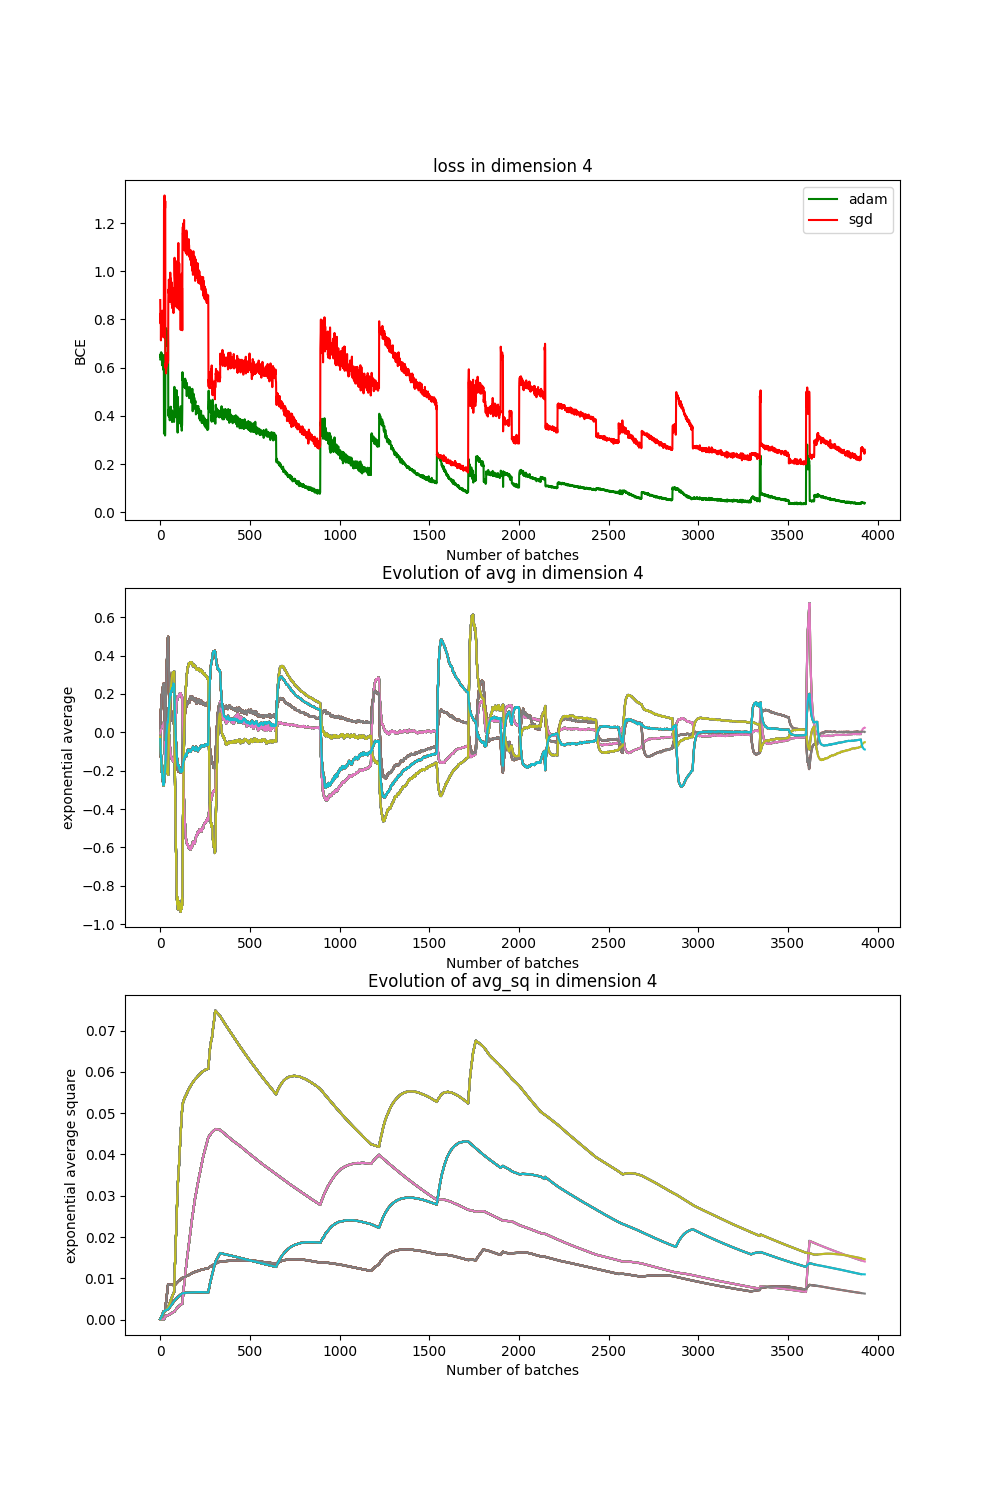

In [17]:
run_experiment(4, 0.9, 0.999)

<IPython.core.display.Javascript object>


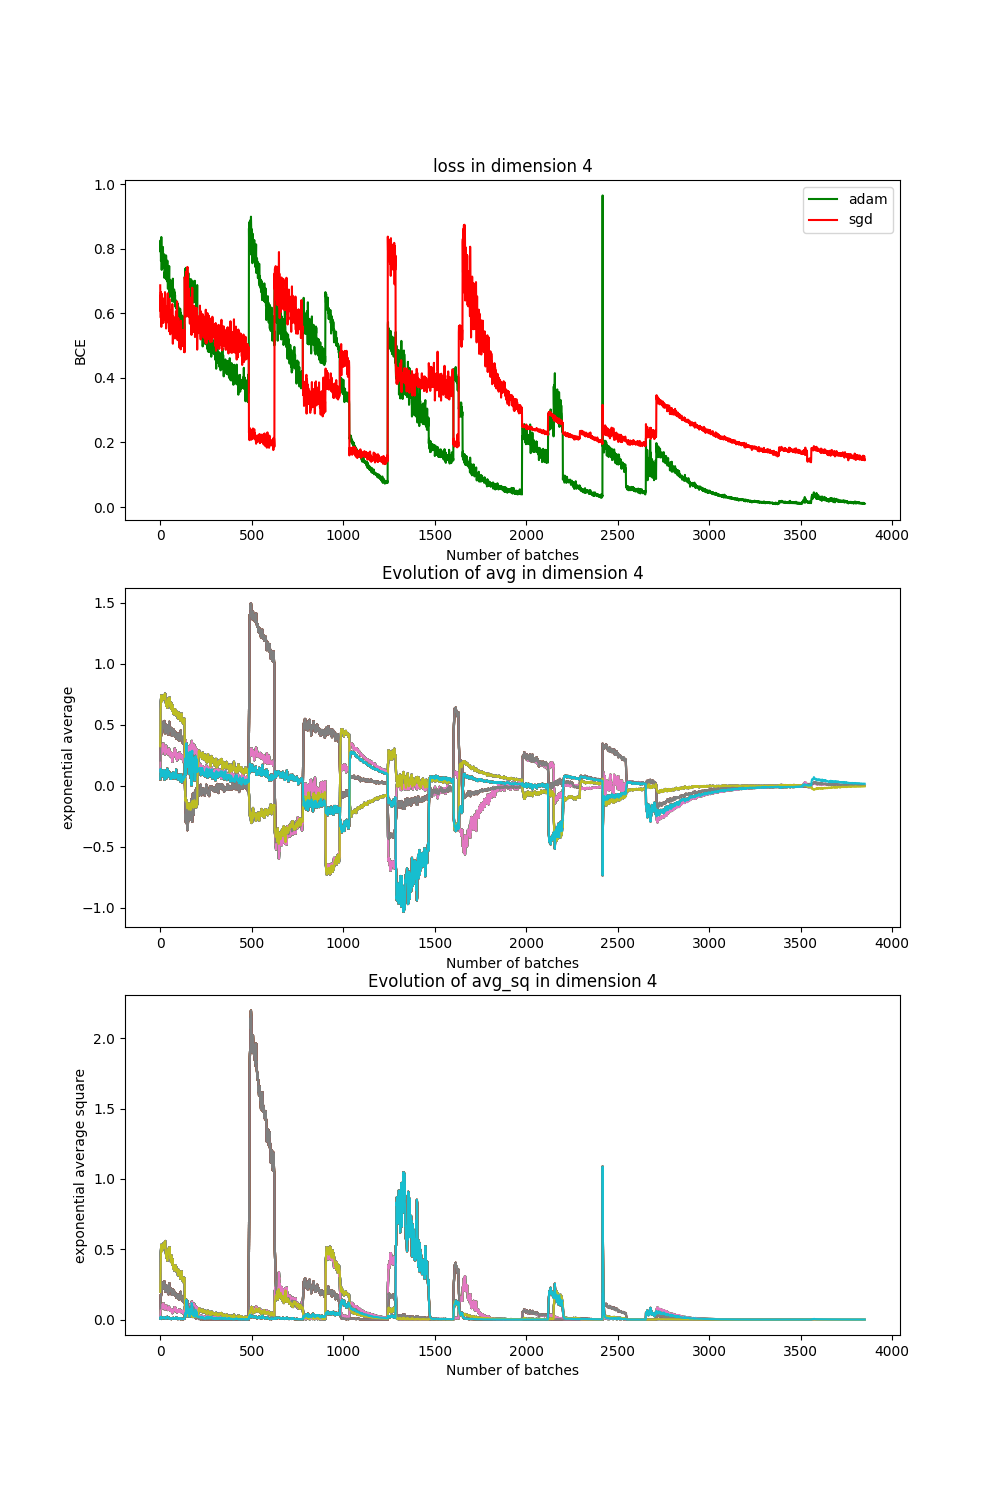

In [18]:
run_experiment(4, 0.6, 0.699)

<IPython.core.display.Javascript object>


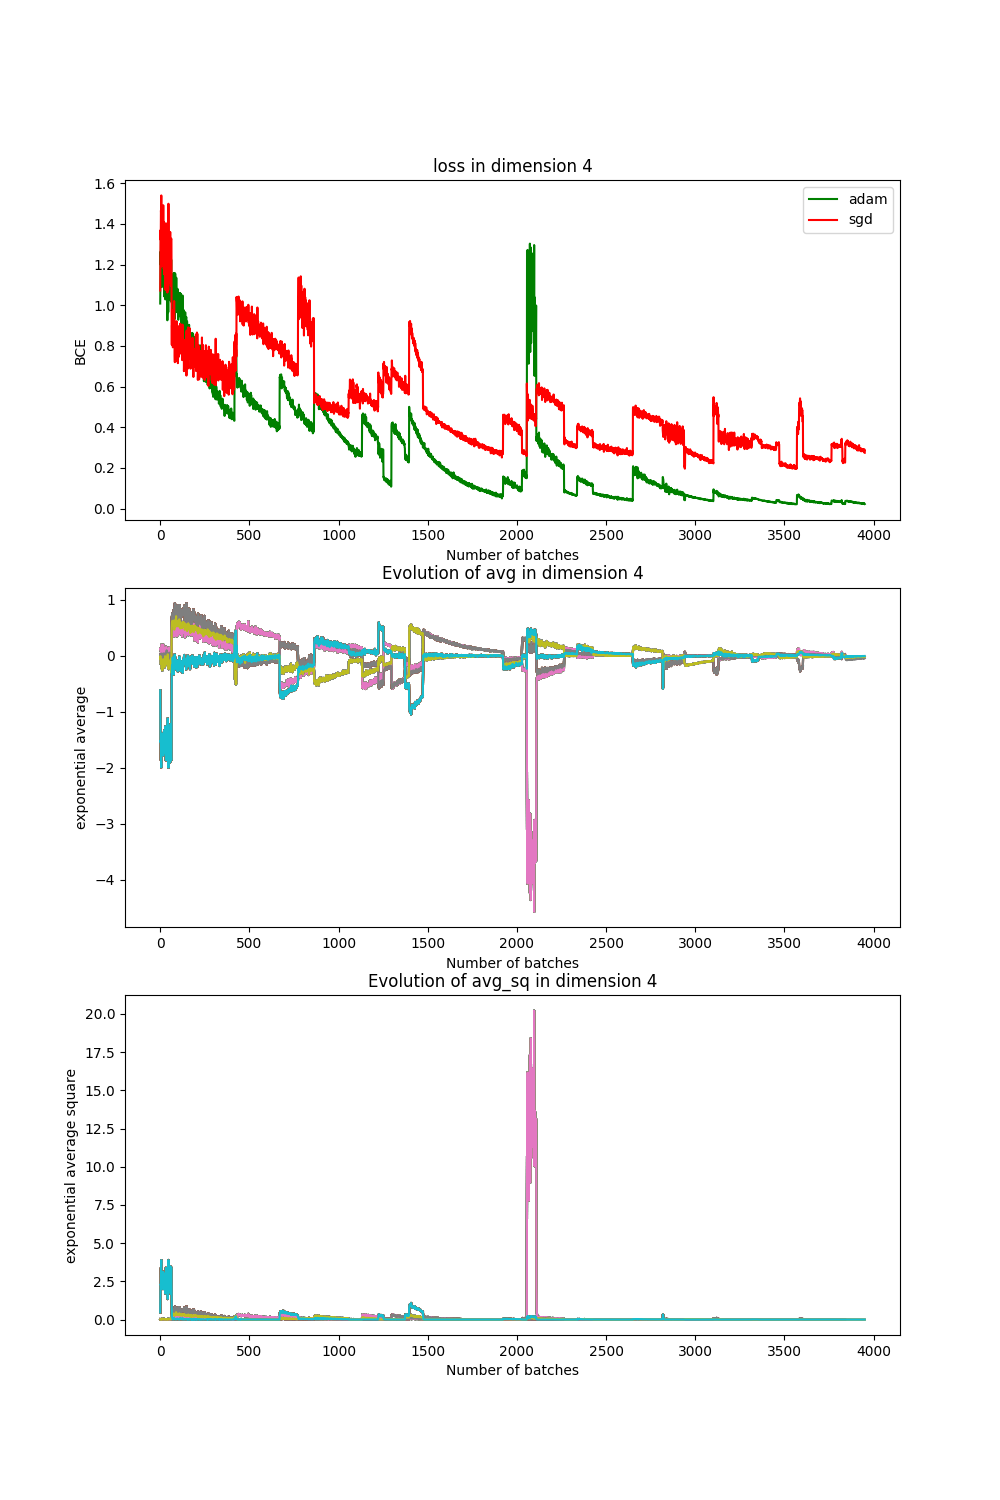

In [19]:
run_experiment(4, 0.3, 0.399)